In [15]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
import os, sys
import warnings
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from scipy import stats
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.colors import LogNorm
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

In [2]:
orgData_dir = "~/jordan/MDwarf/dataset/catalogs/preMS_cand.csv"
orgData_df = pd.read_csv(orgData_dir)

print(orgData_df.columns, orgData_df.shape)

Index(['obsid', 'designation', 'obsdate', 'lmjd', 'mjd', 'planid', 'spid',
       'fiberid', 'ra_obs', 'dec_obs', 'snru', 'snrg', 'snrr', 'snri', 'snrz',
       'class', 'subclass', 'z', 'z_err', 'magtype', 'ra', 'dec', 'ewha',
       'ewha_err', 'type', 'na', 'id', 'RA_ICRS', 'DE_ICRS', 'rest',
       'b_rest_x', 'B_rest_xa', 'rlen', 'ResFlag', 'ModFlag', 'source_id',
       'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'duplicated_source', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp',
       'radial_velocity', 'radial_velocity_error', 'rv_nb_transits', 'lum_val',
       'astrometric_chi2_al', 'astrometric_n_good_obs_al'],
      dtype='object') (6788, 59)


In [3]:
# lm = LAMOST(dataset=6)
# lm.token='AAaHdn8fTr'
# preMS_dir = '/share/data/jdli/preMS/'

# # lm.downloadFits(orgData_dir.obsid[0], savedir='./dataset/dr6/')
# for i,obsid in tqdm(enumerate(orgData_df.obsid)):
#     lm.downloadFits(orgData_df.obsid[i], 
#                     savedir=preMS_dir)

In [17]:
from laspec.read_spectrum import read_spectrum
from laspec.lamost import lamost_filepath

from laspec.group_specs import groupSpec
from laspec.line_indices import measure_line_index

from slam.normalization import normalize_spectrum, normalize_spectra_block

In [18]:
fp = '/share/data/jdli/preMS/'
GroupSpec = groupSpec(fp)

wave_interp = np.load("/share/data/jdli/wave_interp_R1800.npz")['wave']

In [24]:
from scipy.interpolate import interp1d

fluxes, invars = [], []

def resample(wave, flux, err, wave_resamp):

    
    f1 = interp1d(wave, flux, kind='cubic')
    f2 = interp1d(wave, err)
    re_flux = f1(wave_resamp)
    re_err = f2(wave_resamp)
        
    return np.array(re_flux), np.array(re_err)

for i in tqdm(range(len(GroupSpec))):
    reflux, reivar = resample(GroupSpec[i]['wave'], GroupSpec[i]['flux'], 
                              GroupSpec[i]['ivar'], wave_interp)
    fluxes += [reflux]
    invars += [reivar]
    
fluxes, invars = np.array(fluxes), np.array(invars)

100%|██████████| 6788/6788 [02:32<00:00, 44.44it/s]


In [26]:

fluxes_norm, fluxes_cont = normalize_spectra_block(wave_interp, fluxes, 
                                                   (6147., 8910.), 10., p=(1E-8, 1E-7), q=0.7, 
                                                   eps=1E-19, rsv_frac=2., n_jobs=64, verbose=5)

invars_norm = fluxes_cont**2*invars

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=64)]: Done 160 tasks      | elapsed:   10.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   12.4s
[Parallel(n_jobs=64)]: Done 520 tasks      | elapsed:   13.7s
[Parallel(n_jobs=64)]: Done 754 tasks      | elapsed:   15.6s
[Parallel(n_jobs=64)]: Done 1024 tasks      | elapsed:   17.7s
[Parallel(n_jobs=64)]: Done 1330 tasks      | elapsed:   21.4s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   24.7s
[Parallel(n_jobs=64)]: Done 2050 tasks      | elapsed:   28.5s
[Parallel(n_jobs=64)]: Done 2464 tasks      | elapsed:   32.4s
[Parallel(n_jobs=64)]: Done 2914 tasks      | elapsed:   35.2s
[Parallel(n_jobs=64)]: Done 3400 tasks      | elapsed:   39.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   42.8s
[Parallel(n_jobs=64)]: Done 4480 tasks      | elapsed:   48.0s
[Parallel(n_jobs=64)]: Done 5074 tasks      | 

In [27]:
# idx = 500
# spec = GroupSpec[idx]

# z = 0.00205785
line_info_dib6708 = {'line_center':         6708,
                     'line_range':          (6703, 6713),
                     'line_shoulder_left':  (6690, 6603),
                     'line_shoulder_right': (6713, 6720)}

# line_indx = measure_line_index(wave=spec['wave'],
#                                flux=spec['flux'],
#                                line_info=line_info_dib6708,
#                                num_refit=(100, 0),
#                                return_type='dict',
#                                verbose=True,
#                                z=z)

In [8]:
for key in line_indx.keys():
        print(key, line_indx[key])
#         print(np.sum(np.isnan(line_indx.values())))

SN_local_flux_err 91.24238586425781
SN_local_flux_std 24.18387334297257
num_bad_pixel 0
EW_int -1.1661729
EW_int_err 0.14746949296504244
mod_linear_slope 1.4158288677306285
mod_linear_slope_err 2.5817063315088746
mod_linear_intercept -9420.183063868893
mod_linear_intercept_err 17344.967231558516
mod_gauss_amplitude -62.74637891624139
mod_gauss_amplitude_err 2005.4655442356507
mod_gauss_center 6667.919648075388
mod_gauss_center_err 423.05412841704054
mod_gauss_sigma 17.516047539596418
mod_gauss_sigma_err 125.14715968407327
mod_gauss_amplitude_std nan
mod_gauss_center_std nan
mod_gauss_sigma_std nan


In [28]:
li_indexes = []
obsids = []
for idx in tqdm(range(len(GroupSpec))):
    spec = GroupSpec[idx]
    line_indx = measure_line_index(wave=wave_interp, 
                                   flux=fluxes_norm[idx], 
                                   line_info=line_info_dib6708,
                                   num_refit=(100, 0), return_type='dict',
                                   verbose=True, 
                                   z=orgData_df['z'][orgData_df['obsid']==spec['obsid']].values)
    li_indexes += [line_indx['EW_int']]
    obsids += [spec['obsid']]
    
li_indexes = np.array(li_indexes)
obsids = np.array(obsids)

 15%|█▍        | 998/6788 [00:24<01:55, 49.93it/s]/home/jdli/jordan/laspec/laspec/line_indices.py:170: RuntimeWarning: divide by zero encountered in true_divide
  noise_std = np.std(flux_shoulder / cont_shoulder)
/home/jdli/jordan/laspec/laspec/line_indices.py:170: RuntimeWarning: invalid value encountered in true_divide
  noise_std = np.std(flux_shoulder / cont_shoulder)
/home/jdli/jordan/laspec/laspec/line_indices.py:172: RuntimeWarning: divide by zero encountered in true_divide
  resi_range = 1 - flux_range / cont_range
/home/jdli/jordan/laspec/laspec/line_indices.py:172: RuntimeWarning: invalid value encountered in true_divide
  resi_range = 1 - flux_range / cont_range
/home/jdli/anaconda3/envs/py3x/lib/python3.7/site-packages/lmfit/models.py:60: RuntimeWarning: invalid value encountered in greater
  halfmax_vals = np.where(y > (maxy+miny)/2.0)[0]
100%|██████████| 6788/6788 [03:05<00:00, 36.66it/s]


In [29]:
li_df = pd.DataFrame({'obsid':obsids, 'Li':li_indexes})

li_all_df = pd.merge(li_df, orgData_df, on='obsid')
# print(li_all_df.columns, li_all_df.shape)
li_all_df.to_csv("/share/data/jdli/catalogs/dr6_md_Li.csv",
                 index=False)

# li_all_df = pd.read_csv("/share/data/jdli/catalogs/dr6_md_Li.csv")
print(li_all_df.columns, li_all_df.shape)

Index(['obsid', 'Li', 'designation', 'obsdate', 'lmjd', 'mjd', 'planid',
       'spid', 'fiberid', 'ra_obs', 'dec_obs', 'snru', 'snrg', 'snrr', 'snri',
       'snrz', 'class', 'subclass', 'z', 'z_err', 'magtype', 'ra', 'dec',
       'ewha', 'ewha_err', 'type', 'na', 'id', 'RA_ICRS', 'DE_ICRS', 'rest',
       'b_rest_x', 'B_rest_xa', 'rlen', 'ResFlag', 'ModFlag', 'source_id',
       'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'duplicated_source', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp',
       'radial_velocity', 'radial_velocity_error', 'rv_nb_transits', 'lum_val',
       'astrometric_chi2_al', 'astrometric_n_good_obs_al'],
      dtype='object') (6788, 60)


In [10]:
"""TEST"""
spec = GroupSpec.obsid2spec(obsids, li_all_df['obsid'].iloc[0])

In [30]:
li_safe_idx = (li_all_df['snri']>50.) & (li_all_df['Li']>5.)
li_safe_df = li_all_df[li_safe_idx]
print(li_safe_df.shape)

(20, 60)


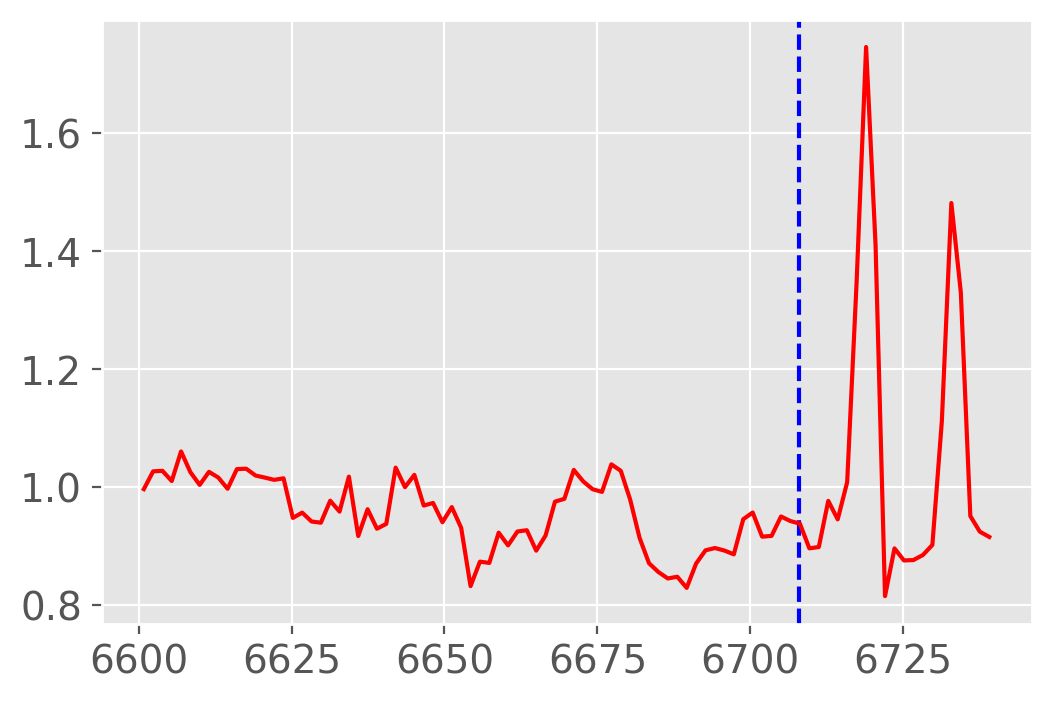

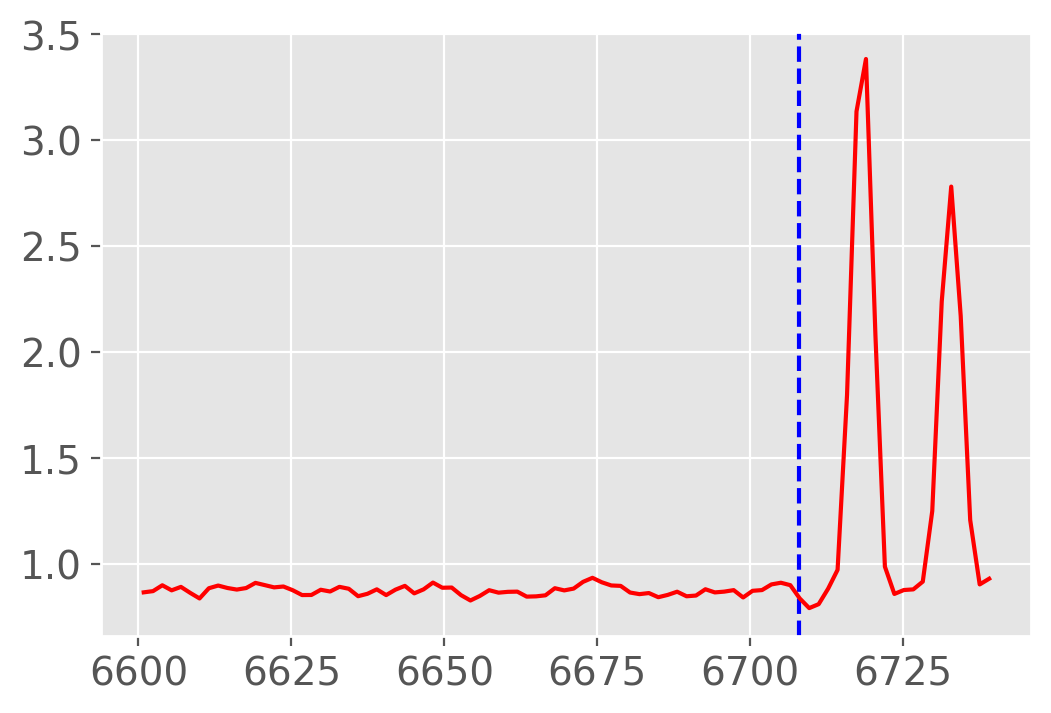

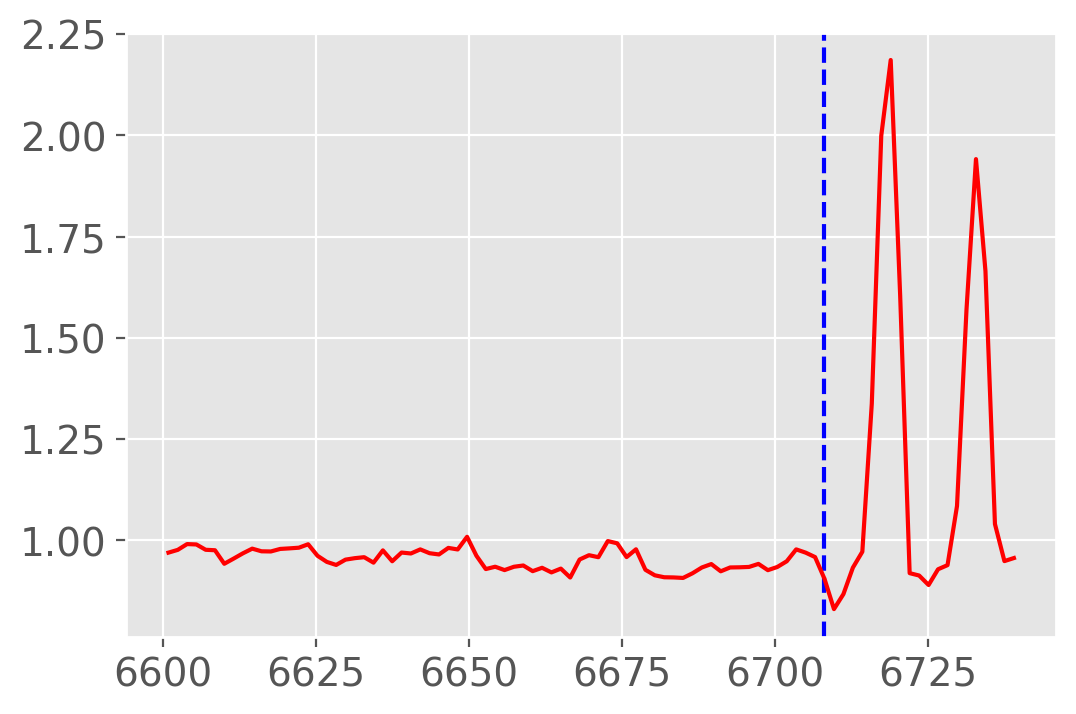

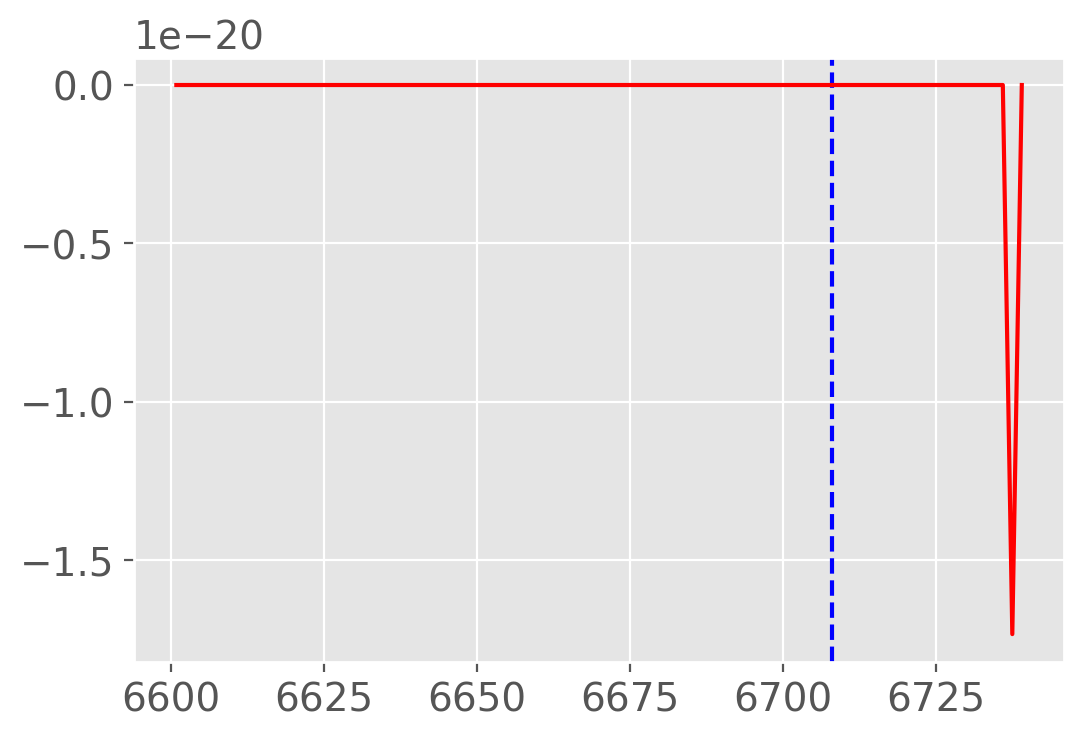

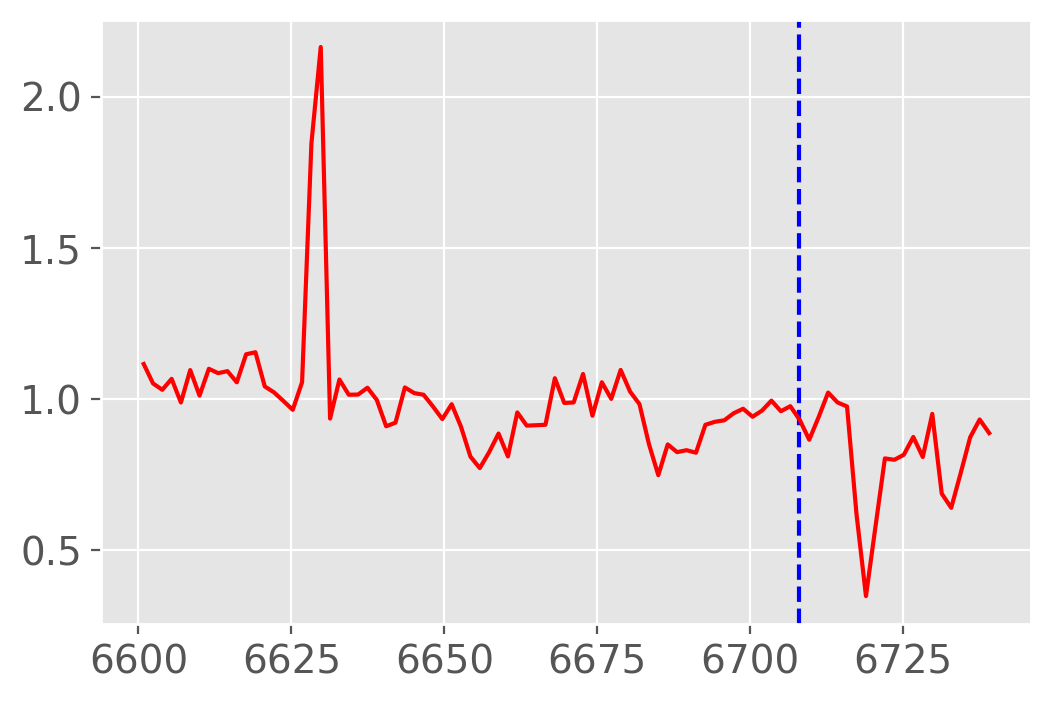

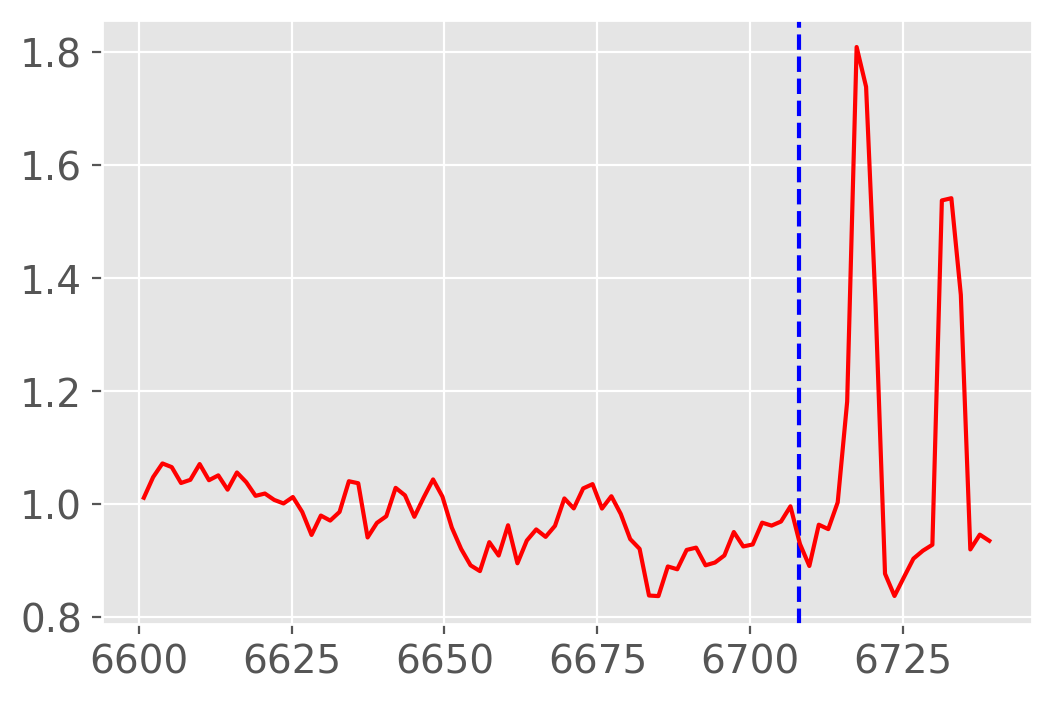

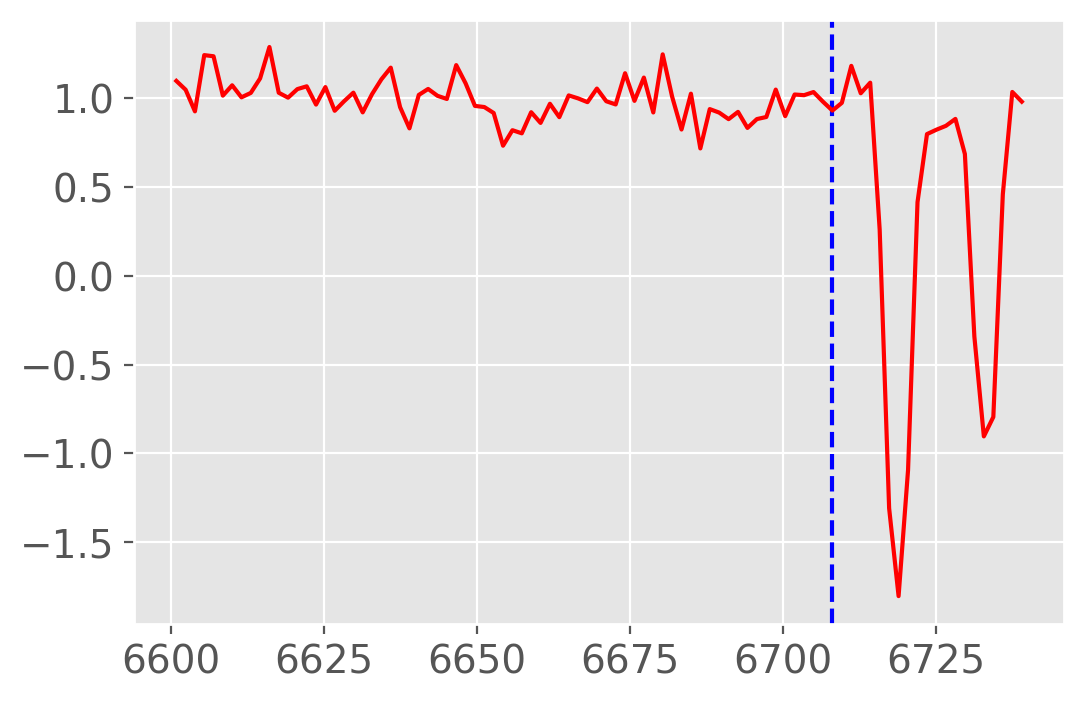

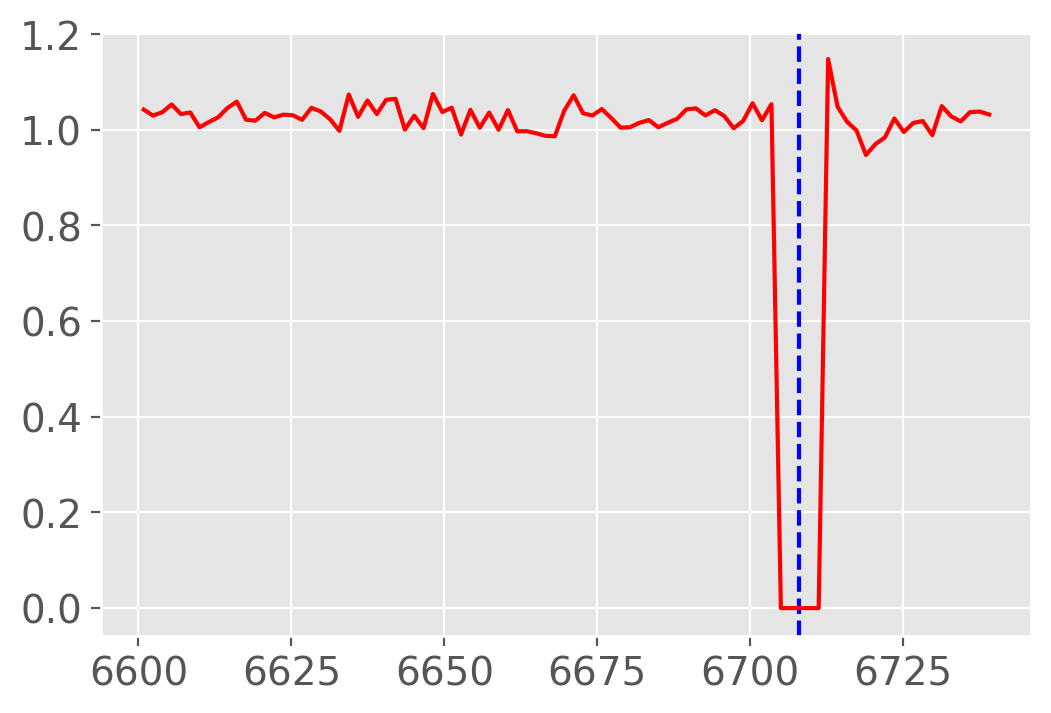

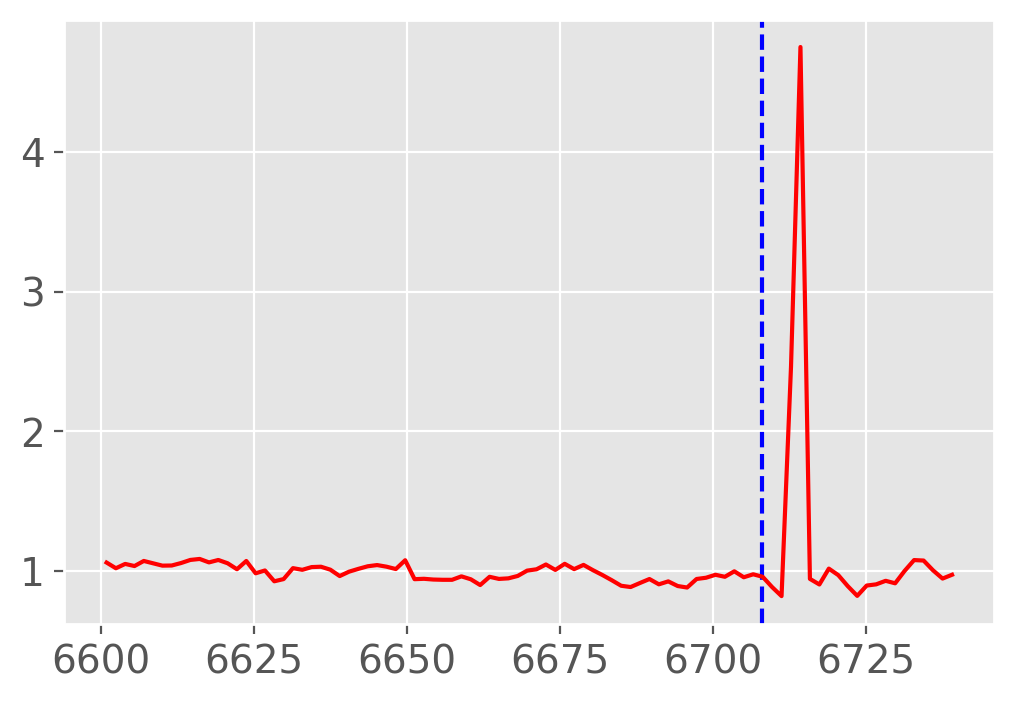

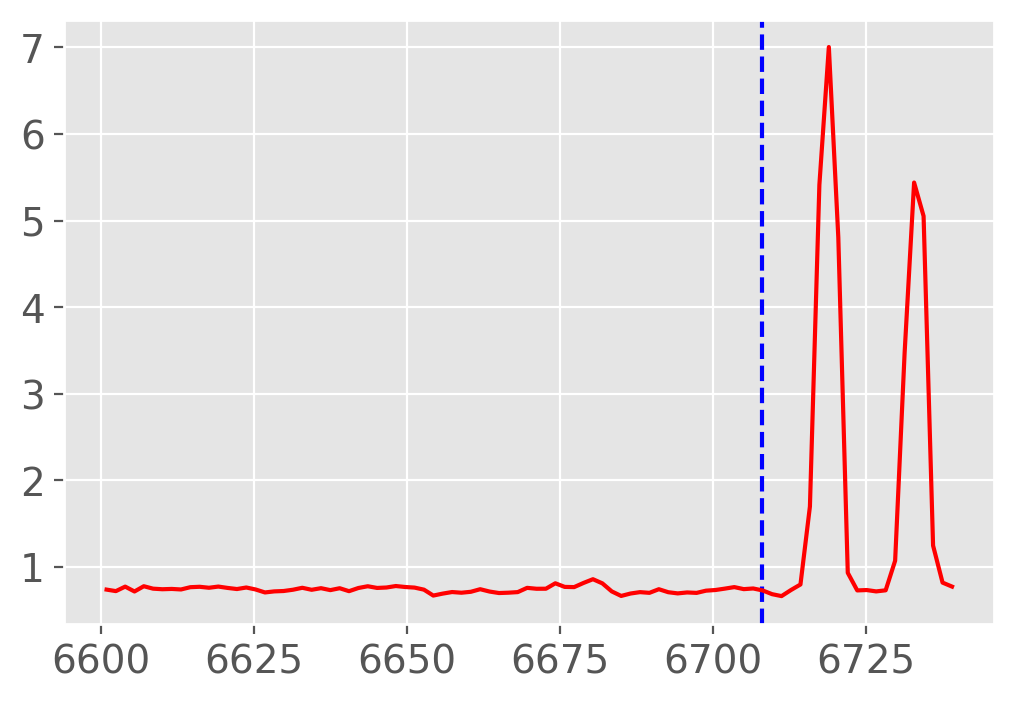

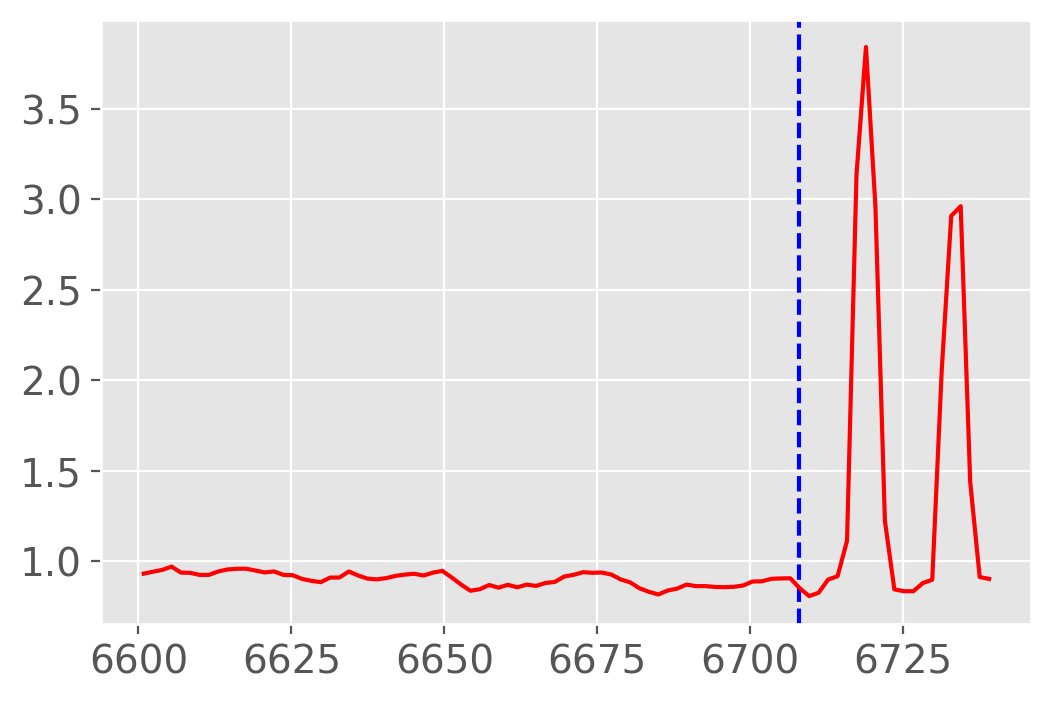

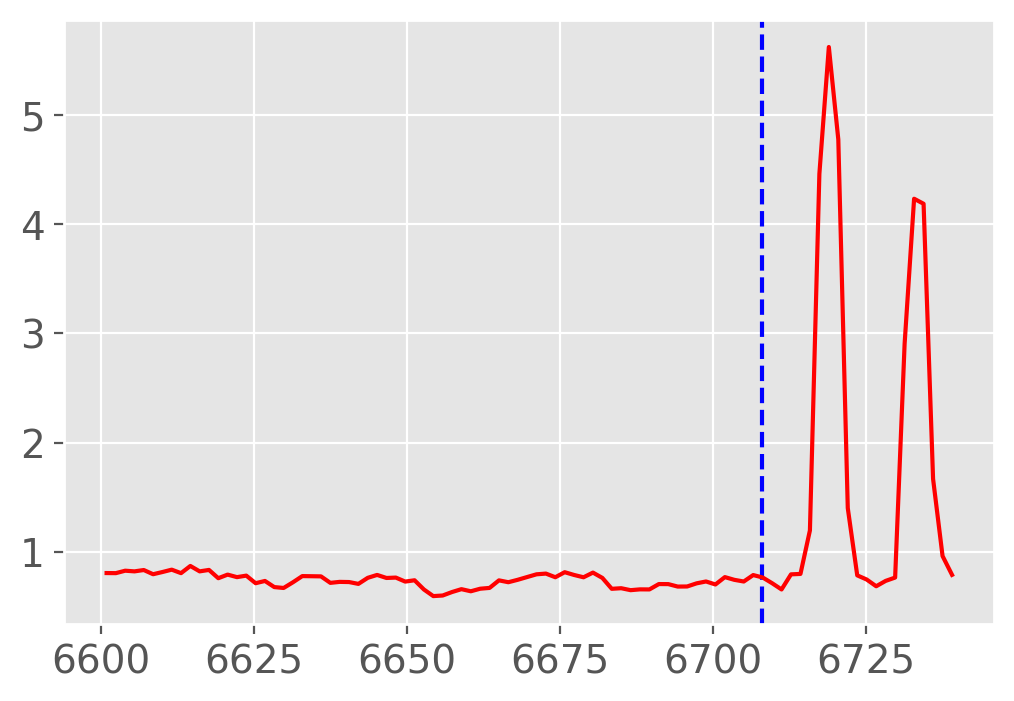

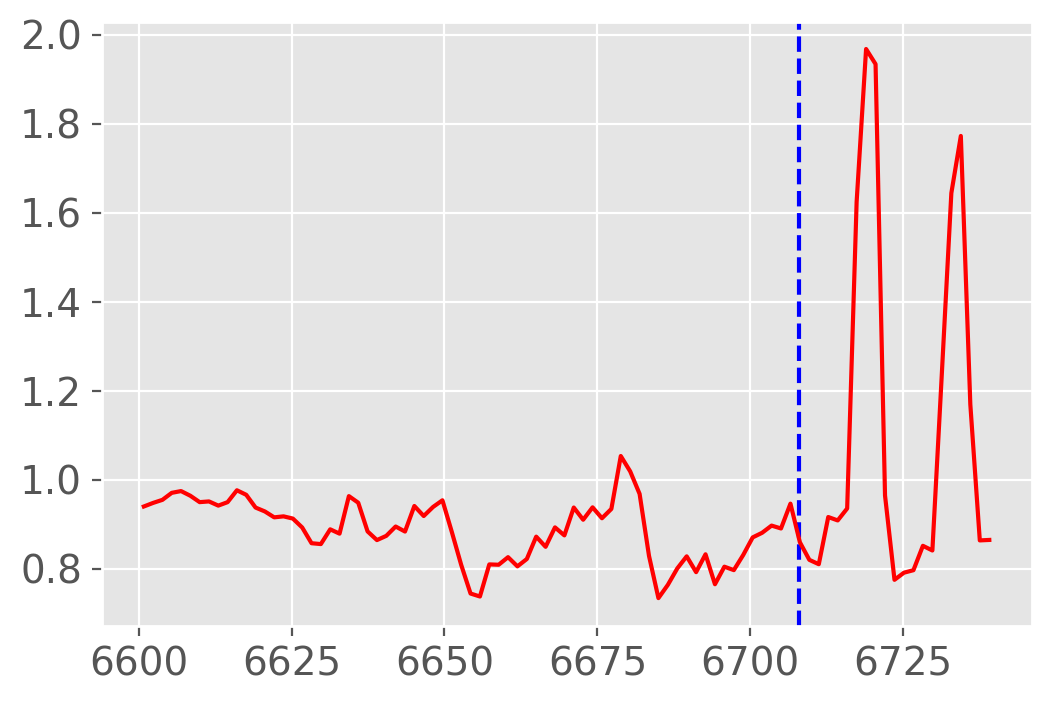

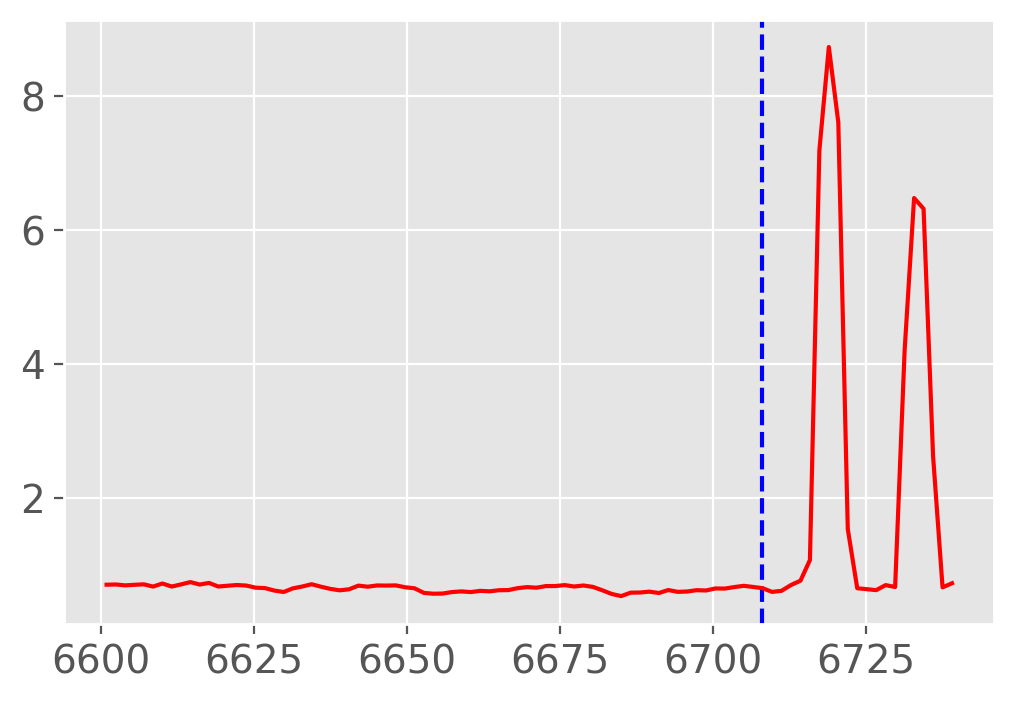

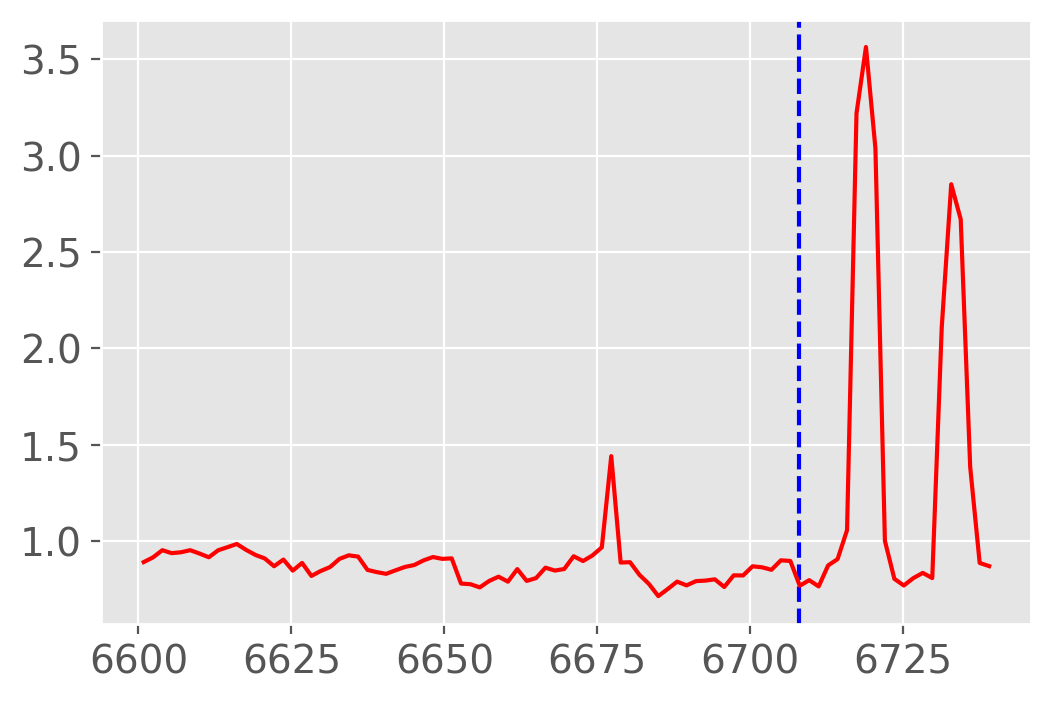

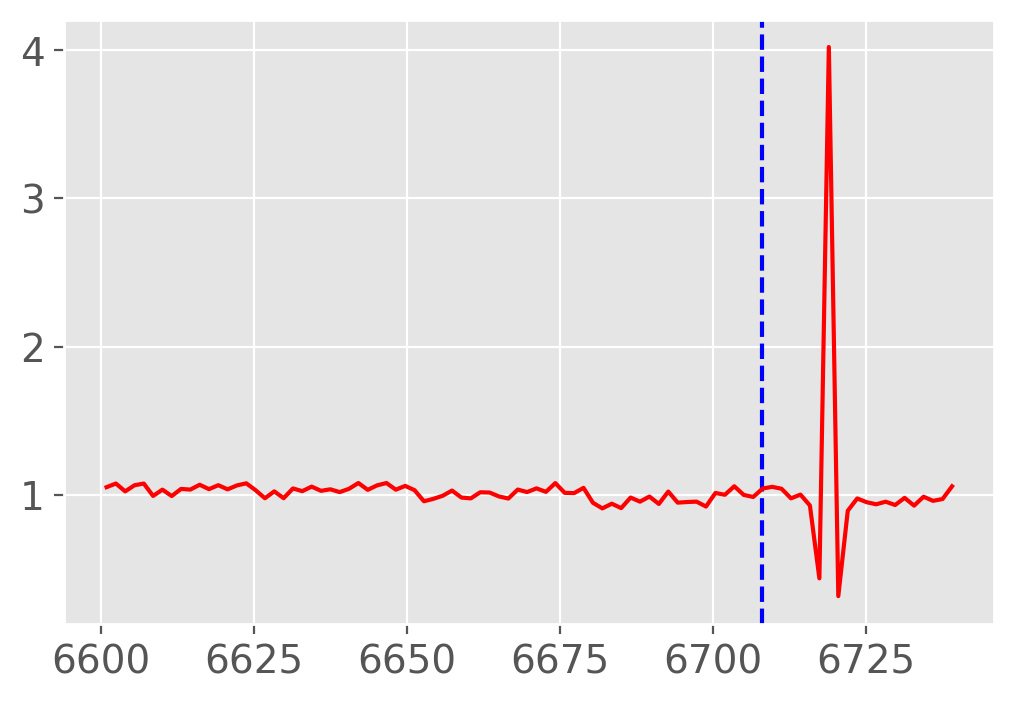

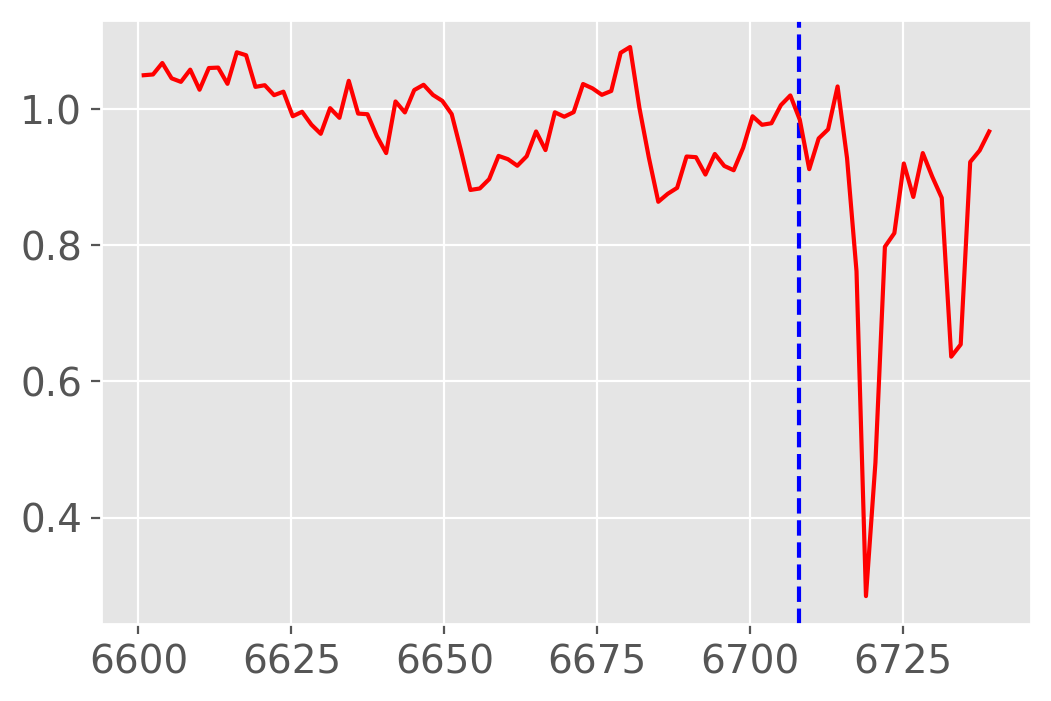

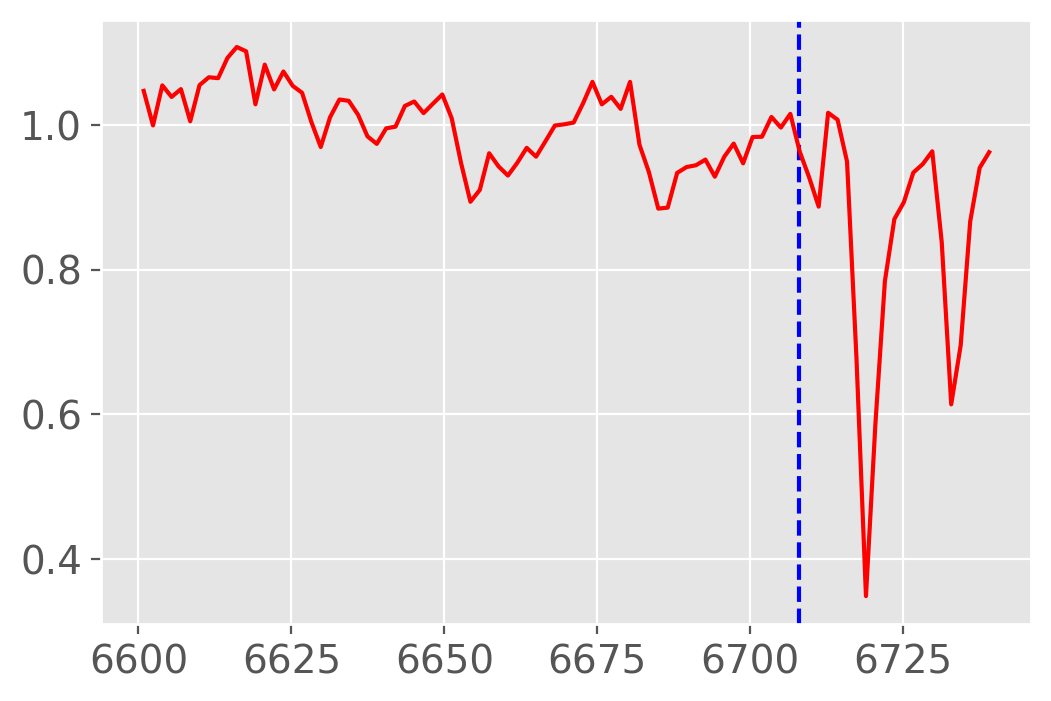

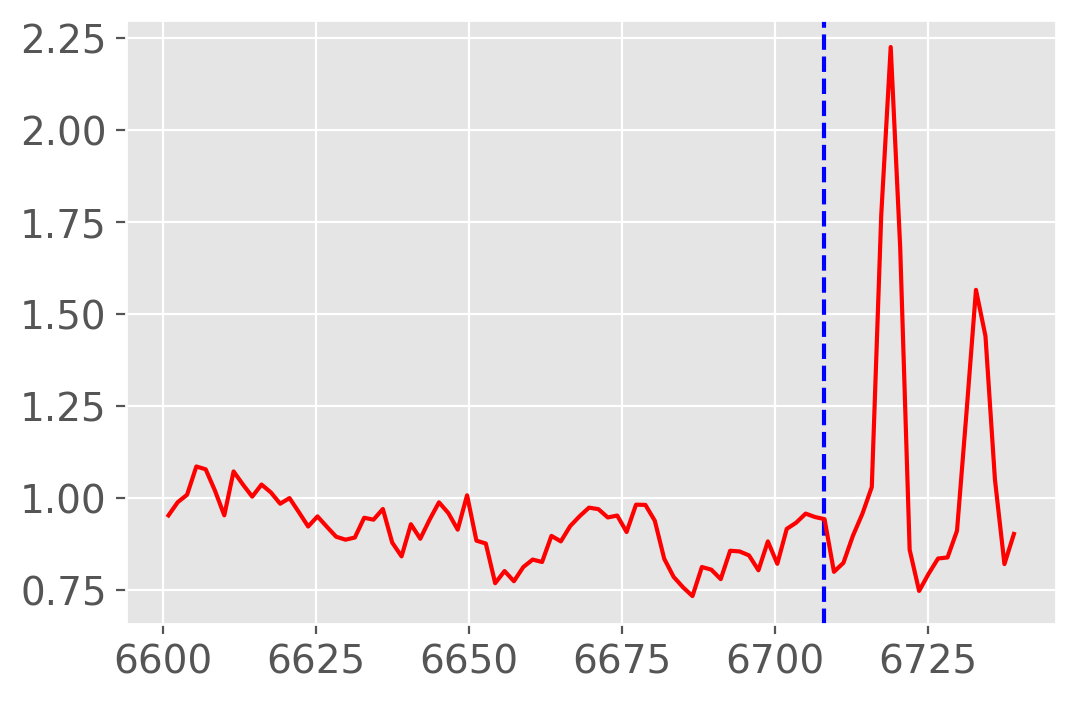

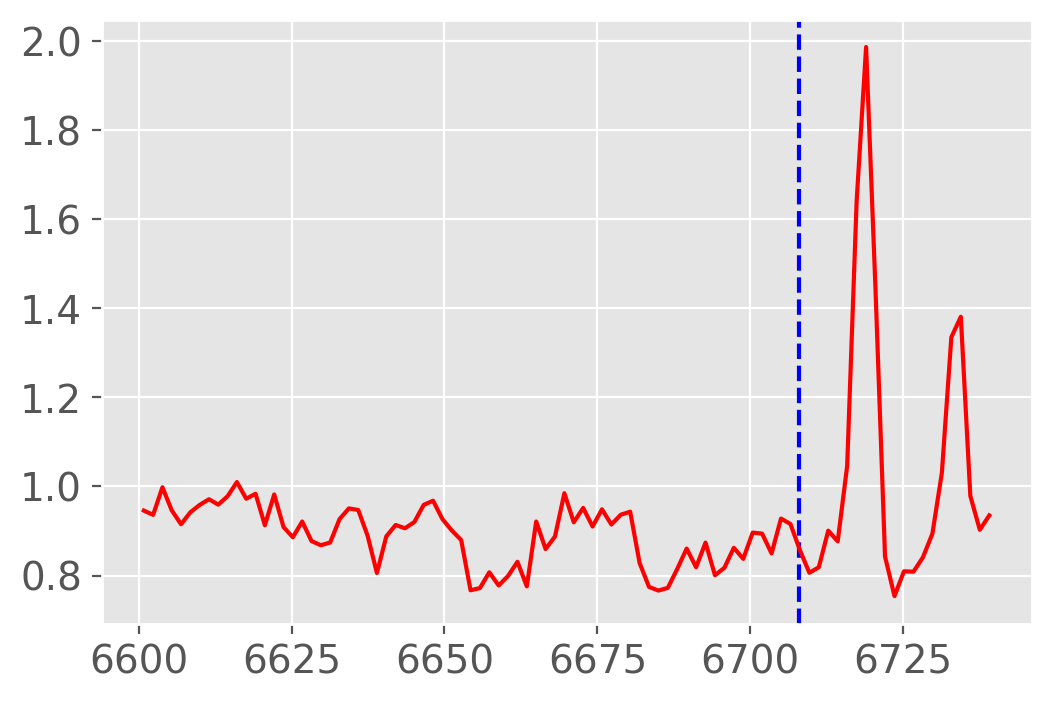

In [34]:
# spec = GroupSpec[353]
for i in range(len(li_safe_df)):
    idx = np.asscalar(np.argwhere(obsids == 
                                  li_safe_df['obsid'].iloc[i]))
    z=np.asscalar(orgData_df['z'][orgData_df['obsid']==
                                  li_safe_df['obsid'].iloc[i]].values)
#     wave, flux = np.array(spec['wave']), np.array(spec['flux'])
    ind_range = (wave_interp > 6600.) & (wave_interp < 6740.)
    fig = plt.figure()
    plt.axvline(x=6708., ls ='--', c='b')
    plt.plot(wave_interp[ind_range]-z, 
             fluxes_norm[idx][ind_range], 'r-')
# plt.plot(wave[ind_range], cont_range, 'b-')
# plt.plot(wave[ind_shoulder], flux[ind_shoulder], 'm-')
# plt.title(r'line' + str(line_info['line_center']) + r'of ' + filename)